# Imports:


In [1]:
%matplotlib notebook
import ast
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import re
import string
import seaborn as sns
import warnings
import email.parser
from datetime import datetime, timedelta
from matplotlib import MatplotlibDeprecationWarning
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)

# 1.Loading And Cleaning:
#### I'm Using The emails package to parse the message column into seprate collumns accroding to the email parts


In [2]:
df = pd.read_csv('emails.csv')
# Parse the emails into a list email objects
emails = list(map(email.message_from_string, df['message']))
# Get fields from parsed email objects
keys = emails[0].keys()
for key in keys:
    df[key] = [form[key] for form in emails]

df.columns

Index(['file', 'message', 'Message-ID', 'Date', 'From', 'To', 'Subject',
       'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'X-From',
       'X-To', 'X-cc', 'X-bcc', 'X-Folder', 'X-Origin', 'X-FileName'],
      dtype='object')

## Helper Functions:


In [3]:
# gets the text from emails
def get_text_from_email(email_msg):
    contents = []
    if email_msg.is_multipart():
        for part in email_msg.get_payload():
            if part.get_content_type() == 'text/plain':
                contents.append(part.get_payload())
    else:
        if email_msg.get_content_type() == 'text/plain':
            contents.append(email_msg.get_payload())
    return ''.join(contents)

# Split a string(df) of email address of senders/receivers to a list of multiple address
def split_email_addresses(address_list):
    if address_list:
        address = address_list.split(',')
        address = list(set(map(lambda x: x.strip(), address)))
    else:
        address = None
    return address

def parse_custom_date(date_str):
    date_str = date_str.replace("0001", "2001")
    date_str = date_str.replace("0000", "2000")
    date_str = date_str.replace("0002", "2002")
    date_str = date_str[:-6].strip()  # Remove offset from date string
    offset_str = date_str[-5:]  # Extract offset string (e.g., -0800)
    dt = datetime.strptime(date_str[:-6].strip(), "%a, %d %b %Y %H:%M:%S")  # Parse date string without offset
    offset_hours = int(offset_str[1:3])
    offset_minutes = int(offset_str[3:5])
    #adding offset
    if offset_str[0] == "-":
        dt += timedelta(hours=offset_hours, minutes=offset_minutes)
    else:
        dt -= timedelta(hours=offset_hours, minutes=offset_minutes)
    return dt

#### now using the helper functions to continue parsing and rearranging the data.
#### filter the dataset according to dates from 01.01.2000 to 30.06.2000

In [4]:
# Parse content from emails
df['Content'] = list(map(get_text_from_email, emails))
# filter the data
df['Date'] = df['Date'].map(parse_custom_date)
df = df.loc[(df['Date'].dt.year == 2000) & (df['Date'].dt.month <= 6)]

# Split multiple email addresses
df['From'] = df['From'].map(split_email_addresses)
df['From'] = df['From'].apply(lambda x: ', '.join(x))
df['To'] = df['To'].map(split_email_addresses)
# clean and rearrange the data
df.drop(['file', 'message', 'Mime-Version', 'Content-Transfer-Encoding', 'Content-Type', 'X-Origin', 'X-FileName'],
        axis=1, inplace=True)
df.rename(columns={'X-cc': 'Cc', 'X-bcc': 'Bcc', 'X-Folder': 'Folder-Name'}, inplace=True)
df = df.dropna().reset_index(drop=True)

cols = list(df.columns.values)
df = df[[cols[0]] + cols[2:5] + [cols[1]] + cols[7:9] + cols[5:7] + [cols[-1]] + [cols[-2]]]

df.head(10)

,Message-ID,From,To,Subject,Date,Cc,Bcc,X-From,X-To,Content,Folder-Name
0,<20174240.1075855690371.JavaMail.evans@thyme>,phillip.allen@enron.com,[stagecoachmama@hotmail.com],Re: Notices,2000-06-30 14:31:00,,,Phillip K Allen,"""Lucy Gonzalez"" <stagecoachmama@hotmail.com> @...","Lucy,\n\nI got your email. I didn't have time...",\Phillip_Allen_Dec2000\Notes Folders\'sent mail
1,<920154.1075855690394.JavaMail.evans@thyme>,phillip.allen@enron.com,[ina.rangel@enron.com],(Reminder) Update GIS Information,2000-06-30 12:54:00,,,Phillip K Allen,Ina Rangel,What is GIS info? Can you do this?\n\n\n\n---...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail
2,<29996655.1075855690416.JavaMail.evans@thyme>,phillip.allen@enron.com,"[keith.holst@enron.com, mike.grigsby@enron.com]",West Power Strategy Materials,2000-06-27 16:40:00,,,Phillip K Allen,"Mike Grigsby, Keith Holst",---------------------- Forwarded by Phillip K ...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail
3,<32005218.1075855690438.JavaMail.evans@thyme>,phillip.allen@enron.com,[kenneth.shulklapper@enron.com],gas storage model,2000-06-27 12:33:00,,,Phillip K Allen,Kenneth Shulklapper,---------------------- Forwarded by Phillip K ...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail
4,<612127.1075855690459.JavaMail.evans@thyme>,phillip.allen@enron.com,[stouchstone@natsource.com],Re:,2000-06-26 14:54:00,,,Phillip K Allen,Steve Touchstone <STouchstone@natsource.com>,is your voice healed or are you going to use a...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail
5,<20364402.1075855690481.JavaMail.evans@thyme>,phillip.allen@enron.com,[stouchstone@natsource.com],Re:,2000-06-26 14:13:00,,,Phillip K Allen,Steve Touchstone <STouchstone@natsource.com>,no,\Phillip_Allen_Dec2000\Notes Folders\'sent mail
6,<9309202.1075855690502.JavaMail.evans@thyme>,phillip.allen@enron.com,[keith.holst@enron.com],Download Frogger before it hops away!,2000-06-26 13:57:00,,,Phillip K Allen,Keith Holst,---------------------- Forwarded by Phillip K ...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail
7,<29012384.1075855690524.JavaMail.evans@thyme>,phillip.allen@enron.com,[torrey.moorer@enron.com],FT-Denver book on EOL,2000-06-23 11:46:00,,,Phillip K Allen,Torrey Moorer,---------------------- Forwarded by Phillip K ...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail
8,<31697227.1075855690545.JavaMail.evans@thyme>,phillip.allen@enron.com,[scott.carter@chase.com],Re: The New Power Company,2000-06-22 07:26:00,,,Phillip K Allen,"""Carter, Scott"" <Scott.Carter@chase.com> @ ENRON","Scott,\n\n I emailed your question to a friend...",\Phillip_Allen_Dec2000\Notes Folders\'sent mail
9,<25139095.1075855690566.JavaMail.evans@thyme>,phillip.allen@enron.com,[stagecoachmama@hotmail.com],Re: Wade,2000-06-13 14:24:00,,,Phillip K Allen,"""Lucy Gonzalez"" <stagecoachmama@hotmail.com> @...","Lucy,\n\n I want to speak to Wade myself. He ...",\Phillip_Allen_Dec2000\Notes Folders\'sent mail


In [5]:
df.shape

(53762, 11)

In [6]:
df.columns

Index(['Message-ID', 'From', 'To', 'Subject', 'Date', 'Cc', 'Bcc', 'X-From',
       'X-To', 'Content', 'Folder-Name'],
      dtype='object')

# 2. Adding edditonal columns
#### creating some columns for further exploration later and saving the modifed data set 

In [7]:
# Lets add a columns for forward content and replays to understand to behaviors of mail sending in enron
def split_content(content):
    content = content.split('---------------------- ', 1)[0].rstrip()
    if content == "":
        return np.nan
    else:
        return content
def split_forward_content(content):
    split_result = content.split('---------------------- ', 1)
    if len(split_result) == 2:
        return split_result[1].lstrip()
    else:
        return np.nan

In [8]:
# Create two new columns - Forward-Content based on if a textual content appears and is forwarded, split the
# content column
df["Is-Forwarded"] = df["Content"].str.contains('---------------------- Forwarded')
df.loc[df["Is-Forwarded"], "Forward-Content"] = df['Content'].map(split_forward_content)
df['Content'] = df['Content'].map(split_content)
# Add new columns for month, day, and hour
df['Month'] = df['Date'].dt.month_name()
df['Day'] = df['Date'].dt.day_name()
df['Hour'] = df['Date'].dt.hour
# Add a column to better understand who replies to whom
df['Is-Reply'] = df['Subject'].str.contains('Re:', case=False).fillna(False)
df.to_csv('modified_emails.csv')
df.head(10)

,Message-ID,From,To,Subject,Date,Cc,Bcc,X-From,X-To,Content,Folder-Name,Is-Forwarded,Forward-Content,Month,Day,Hour,Is-Reply
0,<20174240.1075855690371.JavaMail.evans@thyme>,phillip.allen@enron.com,[stagecoachmama@hotmail.com],Re: Notices,2000-06-30 14:31:00,,,Phillip K Allen,"""Lucy Gonzalez"" <stagecoachmama@hotmail.com> @...","Lucy,\n\nI got your email. I didn't have time...",\Phillip_Allen_Dec2000\Notes Folders\'sent mail,False,NaN,June,Friday,14,True
1,<920154.1075855690394.JavaMail.evans@thyme>,phillip.allen@enron.com,[ina.rangel@enron.com],(Reminder) Update GIS Information,2000-06-30 12:54:00,,,Phillip K Allen,Ina Rangel,What is GIS info? Can you do this?,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,True,Forwarded by Phillip K Allen/HOU/ECT on 06/30/...,June,Friday,12,False
2,<29996655.1075855690416.JavaMail.evans@thyme>,phillip.allen@enron.com,"[keith.holst@enron.com, mike.grigsby@enron.com]",West Power Strategy Materials,2000-06-27 16:40:00,,,Phillip K Allen,"Mike Grigsby, Keith Holst",NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,True,Forwarded by Phillip K Allen/HOU/ECT on 06/27/...,June,Tuesday,16,False
3,<32005218.1075855690438.JavaMail.evans@thyme>,phillip.allen@enron.com,[kenneth.shulklapper@enron.com],gas storage model,2000-06-27 12:33:00,,,Phillip K Allen,Kenneth Shulklapper,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,True,Forwarded by Phillip K Allen/HOU/ECT on 06/27/...,June,Tuesday,12,False
4,<612127.1075855690459.JavaMail.evans@thyme>,phillip.allen@enron.com,[stouchstone@natsource.com],Re:,2000-06-26 14:54:00,,,Phillip K Allen,Steve Touchstone <STouchstone@natsource.com>,is your voice healed or are you going to use a...,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,False,NaN,June,Monday,14,True
5,<20364402.1075855690481.JavaMail.evans@thyme>,phillip.allen@enron.com,[stouchstone@natsource.com],Re:,2000-06-26 14:13:00,,,Phillip K Allen,Steve Touchstone <STouchstone@natsource.com>,no,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,False,NaN,June,Monday,14,True
6,<9309202.1075855690502.JavaMail.evans@thyme>,phillip.allen@enron.com,[keith.holst@enron.com],Download Frogger before it hops away!,2000-06-26 13:57:00,,,Phillip K Allen,Keith Holst,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,True,Forwarded by Phillip K Allen/HOU/ECT on 06/26/...,June,Monday,13,False
7,<29012384.1075855690524.JavaMail.evans@thyme>,phillip.allen@enron.com,[torrey.moorer@enron.com],FT-Denver book on EOL,2000-06-23 11:46:00,,,Phillip K Allen,Torrey Moorer,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,True,Forwarded by Phillip K Allen/HOU/ECT on 06/23/...,June,Friday,11,False
8,<31697227.1075855690545.JavaMail.evans@thyme>,phillip.allen@enron.com,[scott.carter@chase.com],Re: The New Power Company,2000-06-22 07:26:00,,,Phillip K Allen,"""Carter, Scott"" <Scott.Carter@chase.com> @ ENRON","Scott,\n\n I emailed your question to a friend...",\Phillip_Allen_Dec2000\Notes Folders\'sent mail,False,NaN,June,Thursday,7,True
9,<25139095.1075855690566.JavaMail.evans@thyme>,phillip.allen@enron.com,[stagecoachmama@hotmail.com],Re: Wade,2000-06-13 14:24:00,,,Phillip K Allen,"""Lucy Gonzalez"" <stagecoachmama@hotmail.com> @...","Lucy,\n\n I want to speak to Wade myself. He ...",\Phillip_Allen_Dec2000\Notes Folders\'sent mail,False,NaN,June,Tuesday,14,True


# 3. Conducting Data Exploration

In [9]:
filter_df = pd.read_csv('modified_emails.csv')
filter_df['Date'] = pd.to_datetime(filter_df['Date'])

## Email Time Distrubtion

<IPython.core.display.Javascript object>


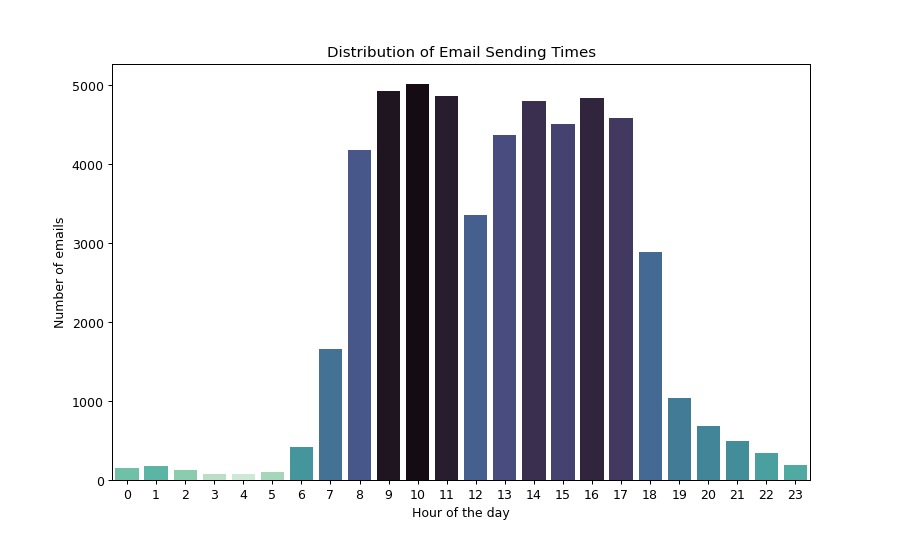

In [10]:
# Create a new DataFrame for visualization
time_df = filter_df.groupby(filter_df['Hour']).size().reset_index(name='count')
time_df.columns = ['hour', 'count']
# Assign colors based on rank
ranks = time_df['count'].rank(method='min', ascending=False)
c_map = sns.color_palette("mako", n_colors=len(time_df))
colors = [c_map[int(rank) - 1] for rank in ranks]

plt.figure(figsize=(10, 6))
# Plot the distribution of email sending times using a bar plot
sns.barplot(data=time_df, x='hour', y='count', palette=colors)
plt.xlabel('Hour of the day')
plt.ylabel('Number of emails')
plt.title('Distribution of Email Sending Times')
plt.show()

## Email Days Distrubtion

<IPython.core.display.Javascript object>


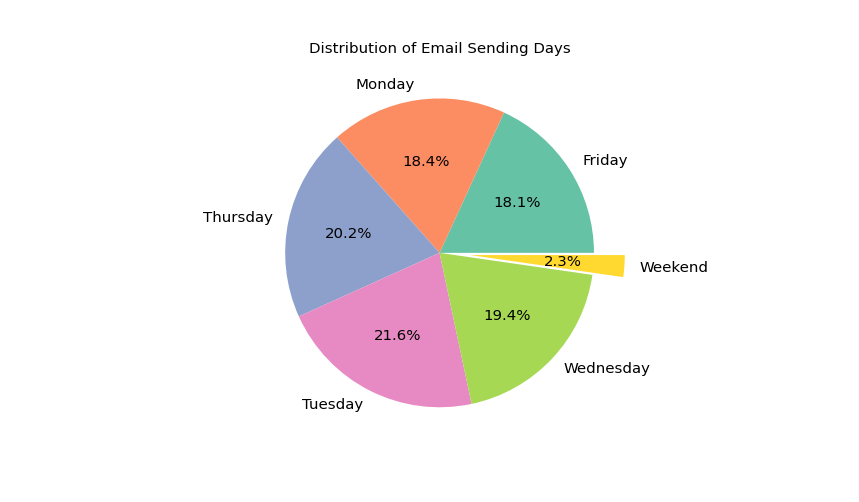

In [11]:
day_df = filter_df.groupby(filter_df['Day']).size().reset_index(name='count')

# Combine Friday and Saturday into a single slice
weekend_count = day_df.loc[day_df['Day'].isin(['Saturday', 'Sunday']), 'count'].sum()
day_df = day_df.loc[~day_df['Day'].isin(['Saturday', 'Sunday'])]

# Create a new DataFrame for the weekend data
weekend_df = pd.DataFrame({'Day': ['Weekend'], 'count': [weekend_count]})

# Concatenate the original DataFrame with the weekend DataFrame
day_df = pd.concat([day_df, weekend_df], ignore_index=True)

# Set the explode parameter to make the "Weekend" slice stand out
explode = [0.0] * (len(day_df) - 1) + [0.2]

# Plot the distribution of email sending days using a pie chart
fig, ax = plt.subplots()
ax.pie(day_df['count'], labels=day_df['Day'], autopct='%1.1f%%', colors=sns.color_palette('Set2'),
       explode=explode, textprops={'fontsize': 12})
ax.set_title('Distribution of Email Sending Days', fontsize=12)
plt.show()

### creating a grouped dataset for later use

In [12]:
filter_df['Word_Count'] = filter_df['Content'].apply(
    lambda x: len(word_tokenize(x)) if isinstance(x, str) else 0)

grouped_df = filter_df.groupby('From').agg(
    Emails_Sent=('Content', 'size'),
    Average_Word_Count=('Word_Count', 'mean'),
    Reply_Count=('Is-Reply', 'sum')
)
grouped_df.to_csv('grouped_emails.csv')
grouped_df = grouped_df.sort_values('Emails_Sent', ascending=False)
grouped_df.head(10)

,Emails_Sent,Average_Word_Count,Reply_Count
From,,,
vince.kaminski@enron.com,4007,99.179935,1796
chris.germany@enron.com,3266,83.926516,1112
carol.clair@enron.com,2178,145.355831,696
sara.shackleton@enron.com,1878,104.367412,542
tana.jones@enron.com,1699,85.326074,517
benjamin.rogers@enron.com,1418,42.744006,483
susan.scott@enron.com,1388,159.047550,490
eric.bass@enron.com,1361,100.578986,717
drew.fossum@enron.com,1271,156.328875,533


## Who Sends The Most Emails?
#### i'll also croos this with the amount of words that they send

<IPython.core.display.Javascript object>


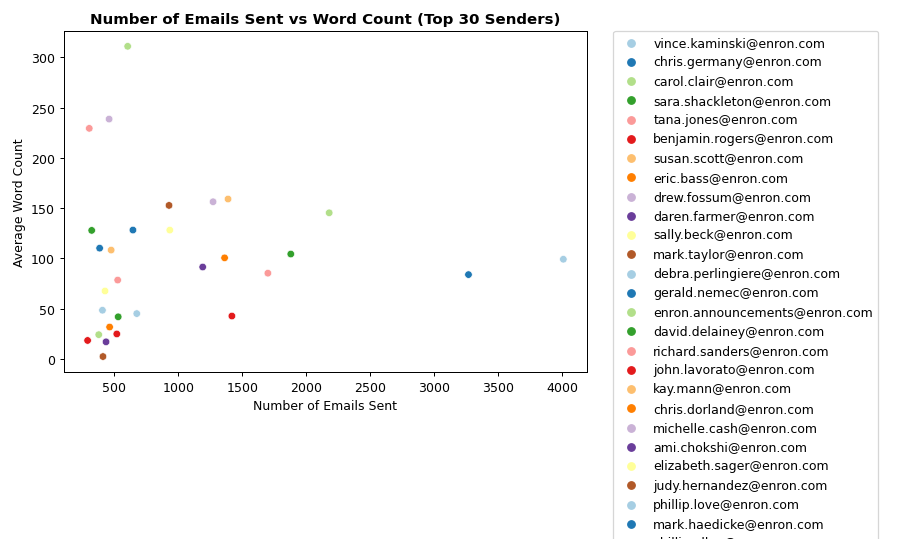

In [13]:
# Scatter plot of number of emails sent vs word count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_df.head(30), x='Emails_Sent', y='Average_Word_Count', hue='From', palette='Paired')
plt.xlabel('Number of Emails Sent')
plt.ylabel('Average Word Count')
plt.title('Number of Emails Sent vs Word Count (Top 30 Senders)', fontweight='bold', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  # Place legend outside the plot
plt.tight_layout()
plt.show()

## Who Sends The Most Replies?

In [14]:
# Sort the DataFrame by number of replies in descending order
grouped_df = grouped_df.sort_values('Reply_Count', ascending=False)
grouped_df.head(10)

,Emails_Sent,Average_Word_Count,Reply_Count
From,,,
vince.kaminski@enron.com,4007,99.179935,1796
chris.germany@enron.com,3266,83.926516,1112
daren.farmer@enron.com,1190,91.463866,804
eric.bass@enron.com,1361,100.578986,717
carol.clair@enron.com,2178,145.355831,696
sara.shackleton@enron.com,1878,104.367412,542
drew.fossum@enron.com,1271,156.328875,533
tana.jones@enron.com,1699,85.326074,517
mark.taylor@enron.com,927,152.701187,494


<IPython.core.display.Javascript object>


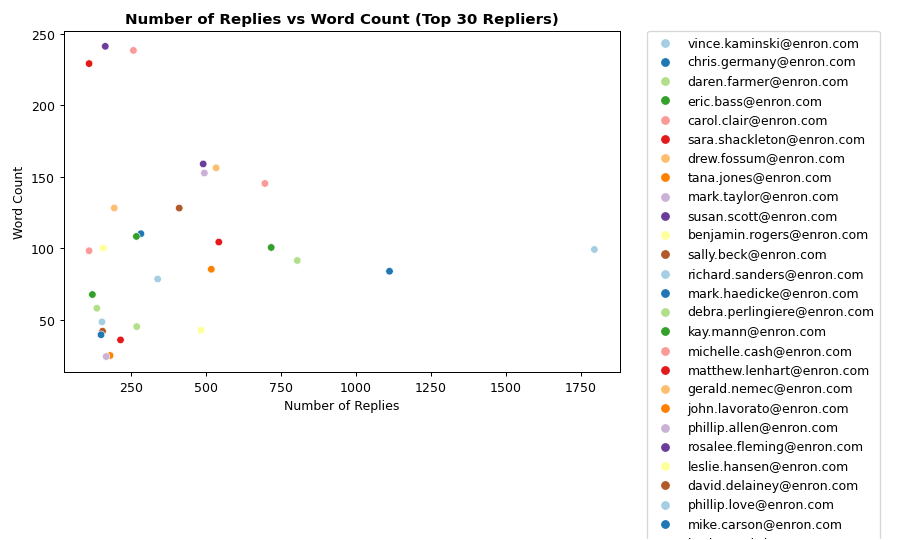

In [15]:
# Scatter plot of number of replies vs word count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=grouped_df.head(30), x='Reply_Count', y='Average_Word_Count', hue='From', palette='Paired')
plt.xlabel('Number of Replies')
plt.ylabel('Word Count')
plt.title('Number of Replies vs Word Count (Top 30 Repliers)', fontweight='bold', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  # Place legend outside the plot
plt.tight_layout()
plt.show()


## Lets look at possible spammers - low emails to replay ratio :

<IPython.core.display.Javascript object>


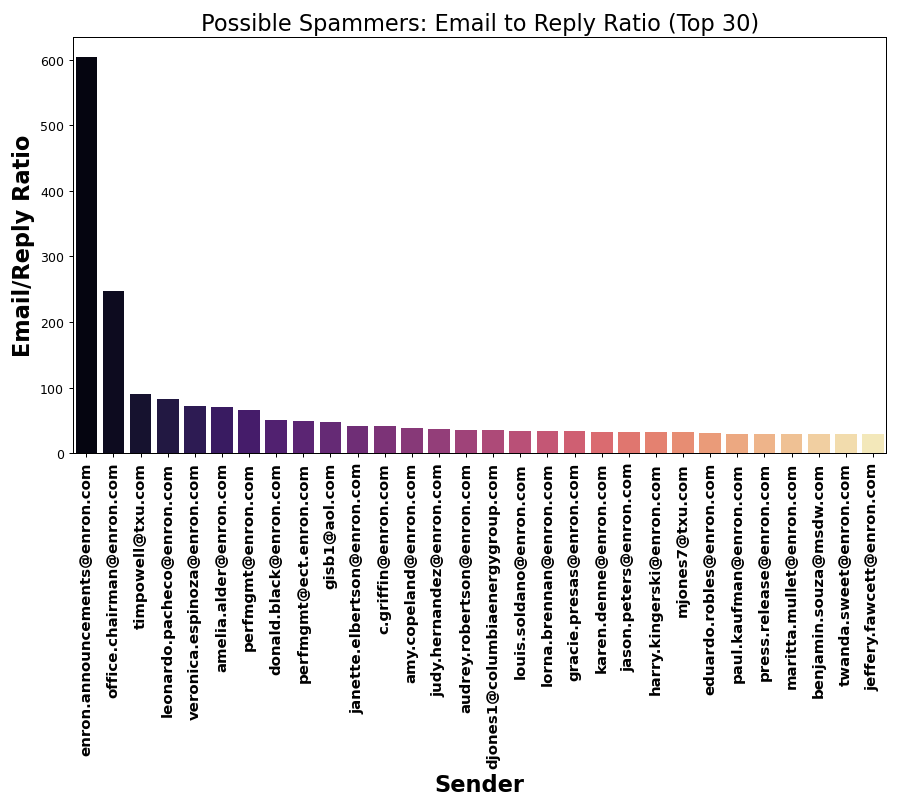

In [16]:
# Calculate the difference between number of emails sent and number of replies
grouped_df['Email_Reply_Ratio'] = np.where(grouped_df['Reply_Count'] == 0, grouped_df['Emails_Sent'],
                                           grouped_df['Emails_Sent'] / grouped_df['Reply_Count'])
# Sort the DataFrame by the difference in descending order
grouped_df = grouped_df.sort_values('Email_Reply_Ratio', ascending=False)
# Create a bar plot of the difference between emails sent and replies
fig, ax = plt.subplots(figsize=(10, 9))
sns.barplot(data=grouped_df.head(30), x=grouped_df.head(30).index, y='Email_Reply_Ratio', palette=sns.color_palette("magma", 30),
            ax=ax)
ax.set_xlabel('Sender', fontweight='bold', fontsize=18)
ax.set_ylabel('Email/Reply Ratio', fontweight='bold', fontsize=18)
ax.set_title('Possible Spammers: Email to Reply Ratio (Top 30)', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontweight='bold', fontsize=12)
plt.tight_layout()
plt.show()

## Who are the most active outsource emailers?

<IPython.core.display.Javascript object>


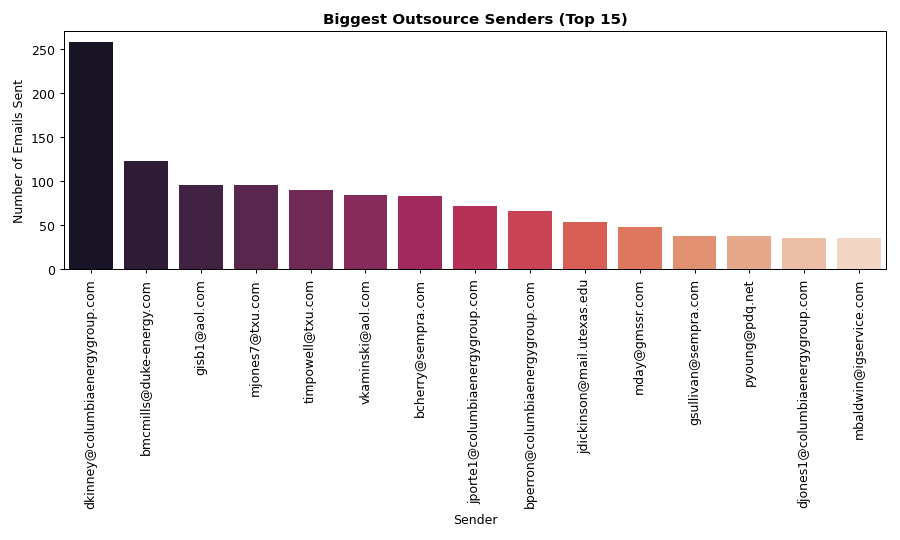

In [21]:
grouped_df = grouped_df.reset_index()
# Filter out the senders that contain 'enron' in the 'From' column
outsource_senders = grouped_df[~grouped_df['From'].str.contains('enron', case=False)]
# Sort the DataFrame by number of emails sent in descending order
outsource_senders = outsource_senders.sort_values('Emails_Sent', ascending=False)

# Bar plot of number of emails sent by outsource senders
plt.figure(figsize=(10, 6))
color_palette = sns.color_palette("rocket", 15)
sns.barplot(data=outsource_senders.head(15), x='From', y='Emails_Sent', palette=color_palette)
plt.xlabel('Sender')
plt.ylabel('Number of Emails Sent')
plt.title('Biggest Outsource Senders (Top 15)', fontweight='bold', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

# Some Graph Plotting :
### first lets look at the top 100 most connected workers

Number of nodes: 105, Number of edges: 88


<IPython.core.display.Javascript object>


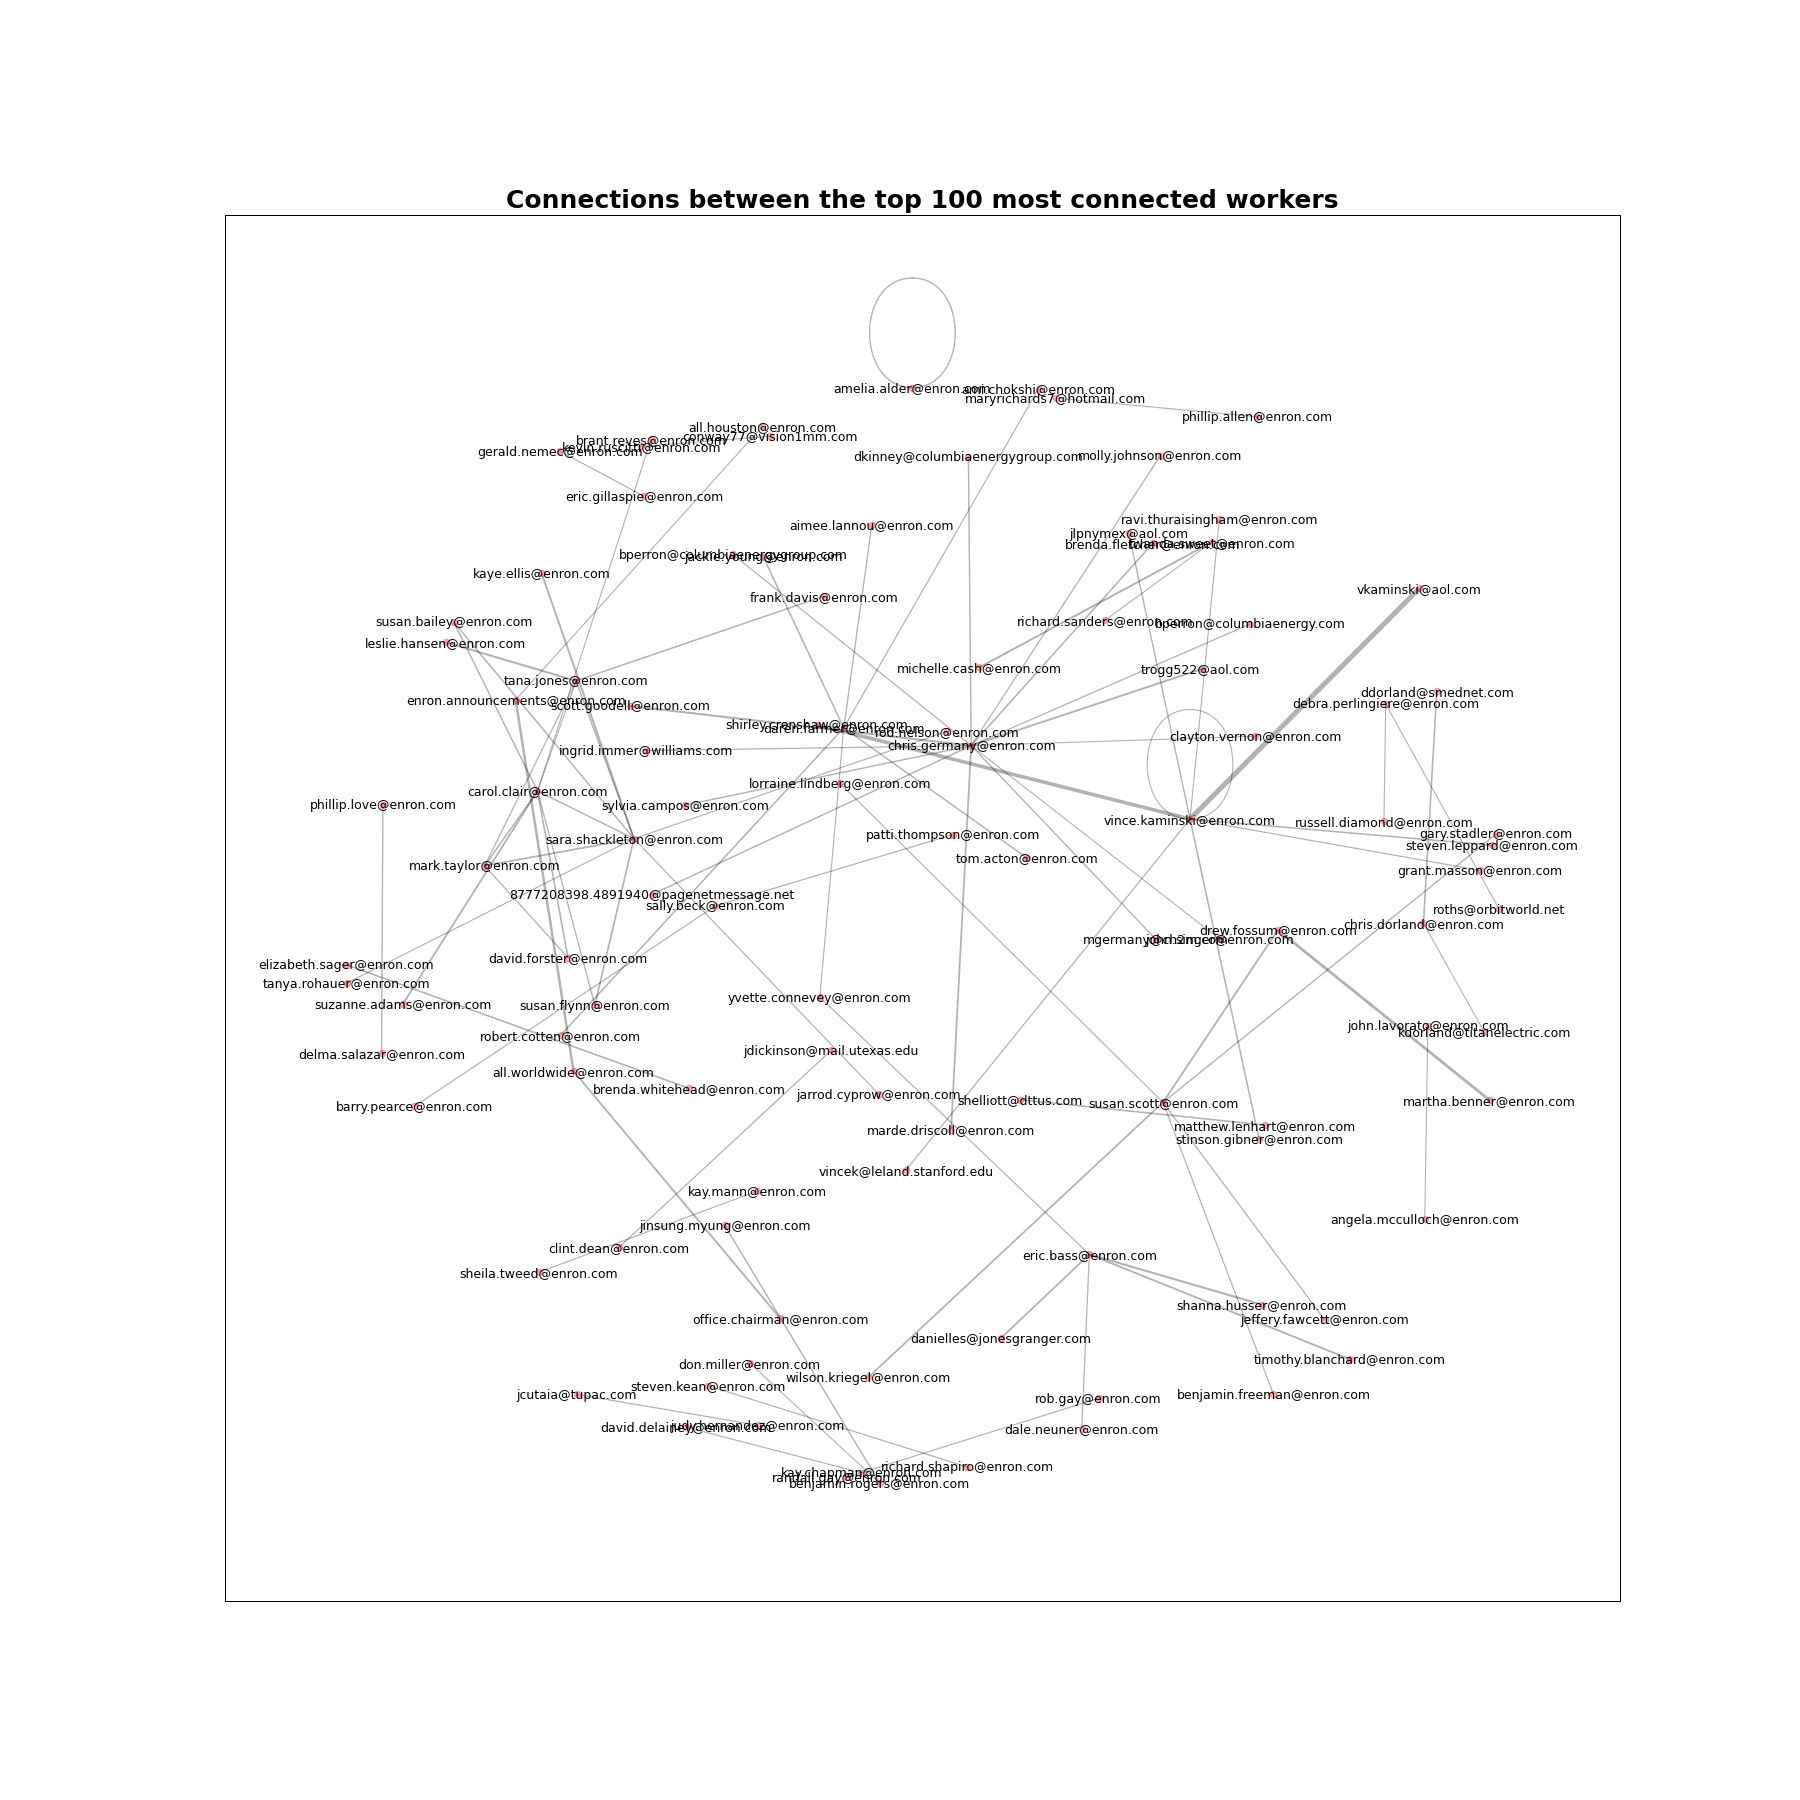

In [22]:
# will only look at the sample since this takes some time
filter_df['To'] = filter_df['To'].apply(ast.literal_eval)
sub_df = filter_df.loc[filter_df['To'].map(len) == 1, ['From', 'To', 'Content']].fillna(0).copy()
sub_df['To'] = sub_df['To'].map(lambda x: x[0])
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
sub_df.rename(columns={'Content': 'count'}, inplace=True)
sub_df_for_graph = sub_df.sort_values('count', ascending=False)

Graph = nx.from_pandas_edgelist(sub_df_for_graph.head(100), source='From', target='To', edge_attr='count')
print('Number of nodes: %d, Number of edges: %d' % (Graph.number_of_nodes(), Graph.number_of_edges()))

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(Graph, k=0.5)

# Compute edge widths based on 'count' attribute
edge_widths = [d['count'] for (_, _, d) in Graph.edges(data=True)]
max_count = max(edge_widths)
edge_widths_normalized = np.power(edge_widths, 0.5) / np.power(max_count, 0.5) * 4


nx.draw_networkx_nodes(Graph, pos, node_size=25, node_color='red', alpha=0.3)
nx.draw_networkx_edges(Graph, pos, edge_color='black', alpha=0.3, width=edge_widths_normalized)
nx.draw_networkx_labels(Graph, pos, font_size=10, font_color='black')
plt.title("Connections between the top 100 most connected workers", fontsize=20, fontweight='bold')
plt.show()


### Now some random workers

Number of nodes: 95, Number of edges: 238


<IPython.core.display.Javascript object>


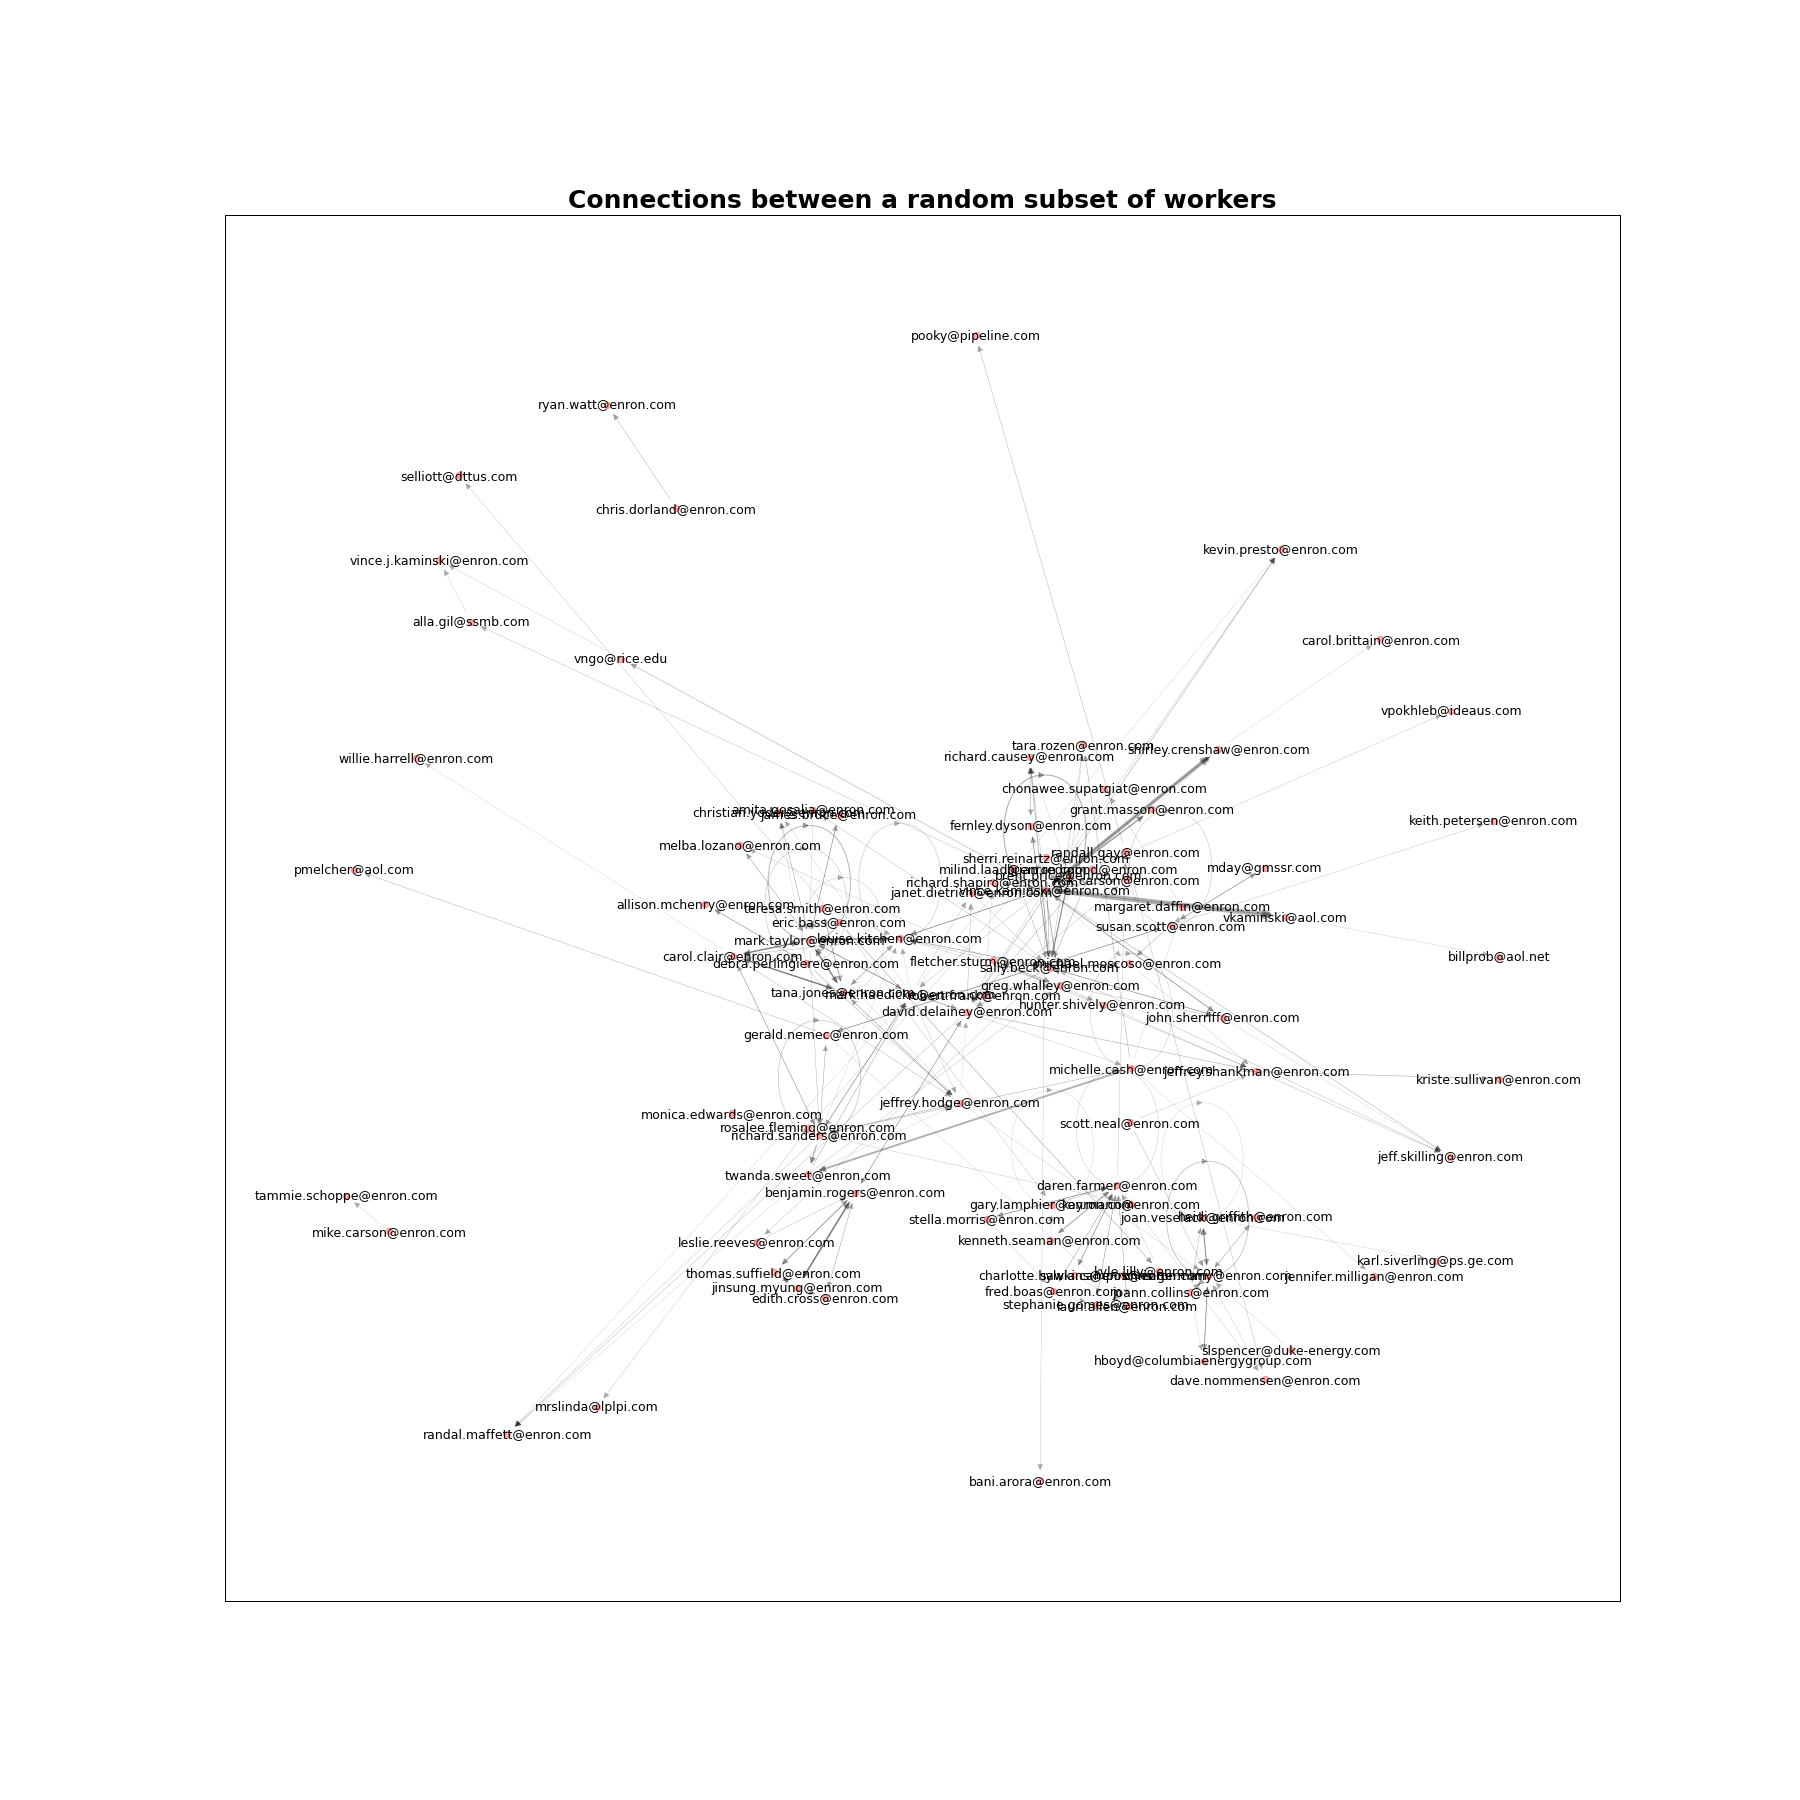

In [23]:
# Select a random subset of 100 nodes from sub_df_for_graph
 # Select a random subset of nodes from sub_df_for_graph
random_subset = sub_df_for_graph.sample(frac=0.01, random_state=0)
random_nodes = np.unique(random_subset[['From', 'To']].values)
sub_df_random = sub_df_for_graph[sub_df_for_graph['From'].isin(random_nodes) & sub_df_for_graph['To'].isin(random_nodes)]

Graph = nx.from_pandas_edgelist(sub_df_random, source='From', target='To', edge_attr='count', create_using=nx.DiGraph)
print('Number of nodes: %d, Number of edges: %d' % (Graph.number_of_nodes(), Graph.number_of_edges()))

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(Graph, k=0.2)

# Compute edge widths based on 'count' attribute
edge_widths = [d['count'] for (_, _, d) in Graph.edges(data=True)]
max_count = max(edge_widths)
edge_widths_normalized = np.power(edge_widths, 0.5) / np.power(max_count, 0.5) * 4

nx.draw_networkx_nodes(Graph, pos, node_size=25, node_color='red', alpha=0.3)
nx.draw_networkx_edges(Graph, pos, edge_color='black', alpha=0.3, width=edge_widths_normalized)
nx.draw_networkx_labels(Graph, pos, font_size=10, font_color='black')

plt.title("Connections between a random subset of workers", fontsize=20, fontweight='bold')
plt.show()

# Which words are the most used?
#### some text cleaning first

In [24]:
#creating a function for cleaning data using removal of stop words, lemma
def text_cleaning(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(('from', 'to', 'cc', 'http', 're', 'www', 'com', 'subject', 'sent', 'email', 'u', 'ok',
                       'thanks', 'please', 'ect', 'dt', 'pm', 'enron'))
    exclude = set(string.punctuation)
    lemma = WordNetLemmatizer()
    text = text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop_words) and (not i.isdigit()) and len(i)>3)])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    return " ".join(lemma.lemmatize(word) for word in punc_free.split())

# will only look at the sample since this takes some time
part_df = filter_df.sample(n=5000, random_state=42).reset_index()
part_df[['Content', 'Subject']] = part_df[['Content', 'Subject']].fillna('')
text_clean = []
for text in part_df['Content']:
    text_clean.append(text_cleaning(text))

subject_clean = []
for sub_text in part_df['Subject']:
    subject_clean.append(text_cleaning(sub_text))

part_df['Clean-Content'] = text_clean
part_df['Clean-Subject'] = subject_clean

part_df.loc[200, 'Subject']

'Re: Current Address for Brad Romine'

In [25]:
part_df.loc[200, 'Clean-Subject']

'current address brad romine'

In [26]:
part_df.loc[200, 'Content']

'Shirley,\n\nI have his cell phone: 650 814 9966.\n\nVince\n\n\n\n\n\nShirley Crenshaw\n03/13/2000 02:15 PM\nTo: Vince J Kaminski/HOU/ECT@ECT\ncc:  \nSubject: Current Address for Brad Romine\n\nVince:\n\nDo you have a current address for Brad?'

In [27]:
part_df.loc[200, 'Clean-Content']

'shirley cell phone vince shirley crenshaw vince kaminski current address brad romine vince current address brad'

## Most used words in Emails 

<IPython.core.display.Javascript object>


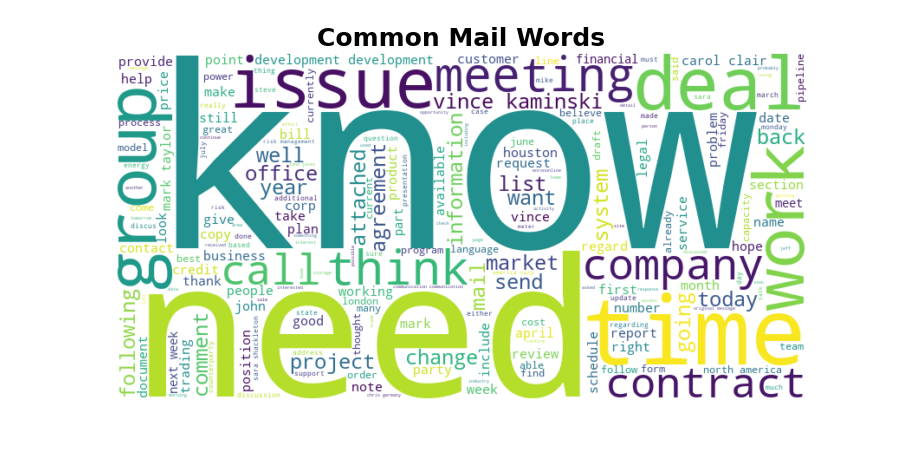

In [28]:
clean_content_text = ' '.join(text_clean)
wordcloud_content = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(clean_content_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_content, interpolation='bilinear')
plt.axis('off')
plt.title('Common Mail Words', fontsize=20, fontweight='bold')
plt.show()

## Most used words in Emails titles

<IPython.core.display.Javascript object>


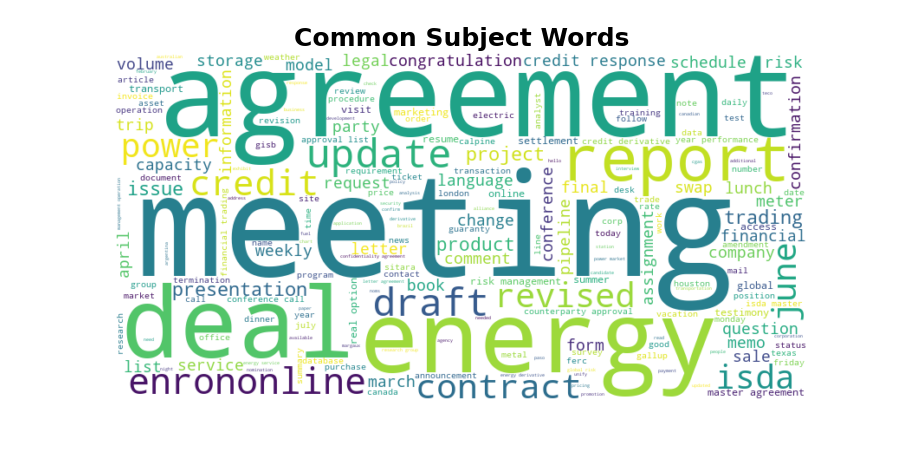

In [29]:
clean_subject_text = ' '.join(subject_clean)
wordcloud_subject = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(clean_subject_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_subject, interpolation='bilinear')
plt.axis('off')
plt.title('Common Subject Words', fontsize=20, fontweight='bold')
plt.show()